# Highway

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/06-deep-reinforcement-learning/07-highway.ipynb)

Let's build an agent able to drive on a [multilane highway](https://github.com/eleurent/highway-env) populated with other vehicles . The agent's objective is to reach a high speed while avoiding collisions with neighbouring vehicles. Driving on the right side of the road is also rewarded.

1. [Setup the environment](#Setup-the-environment)
2. [Setup the agent](#Setup-the-agent)
3. [Training the agent](#Training-the-agent)
4. [Exploit the policy](#Exploit-the-policy)

## Setup the environment

Below is the code snippet to download the environment:

In [26]:
!pip install highway-env > /dev/null 2>&1

We can instantieate it and view the size of each state, as well as the action space:

In [13]:
import gym
import highway_env

env = gym.make("highway-v0")

The environment can be used with several types of observations:

In [35]:
print(env.config['observation'])

{'type': 'Kinematics'}


By default it uses the "KinematicObservation", wich is a array that describes a list of nearby vehicles by a set of features (e.g. position, speed) listed in the "features" configuration field. The agent (ego-vehicle) is always described in the first row.

In [39]:
print('State: ', env.observation_space.shape) 

State:  (5, 5)


Similarly to observations, several types of actions can be used in the environment:

In [40]:
print(env.config['action']) 

{'type': 'DiscreteMetaAction'}


The "DiscreteMetaAction" type adds a layer of speed and steering controllers on top of the continuous low-level control, so that the ego-vehicle can automatically follow the road at a desired velocity. Then, the available actions consist in changing the target lane and speed that are used as setpoints for the low-level controllers.

In [41]:
print(env.get_available_actions())

The environments can be used as a simulation using a human controller:

In [51]:
print(env.config) 

{'observation': {'type': 'Kinematics'}, 'action': {'type': 'DiscreteMetaAction'}, 'simulation_frequency': 15, 'policy_frequency': 1, 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle', 'screen_width': 600, 'screen_height': 150, 'centering_position': [0.3, 0.5], 'scaling': 5.5, 'show_trajectories': False, 'render_agent': True, 'offscreen_rendering': False, 'manual_control': True, 'real_time_rendering': True, 'lanes_count': 4, 'vehicles_count': 50, 'controlled_vehicles': 1, 'initial_lane_id': None, 'duration': 40, 'ego_spacing': 2, 'vehicles_density': 1, 'collision_reward': -1, 'right_lane_reward': 0.1, 'high_speed_reward': 0.4, 'lane_change_reward': 0, 'reward_speed_range': [20, 30], 'offroad_terminal': False}


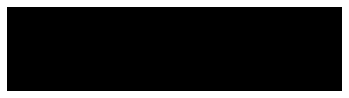

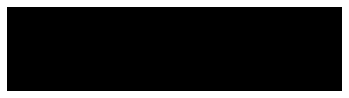

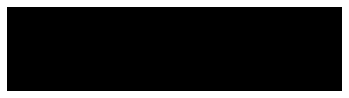

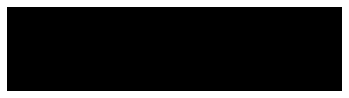

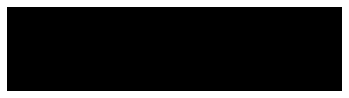

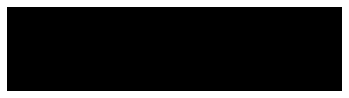

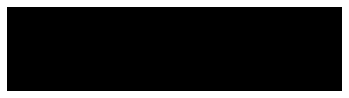

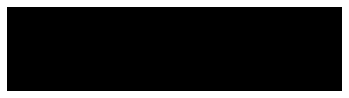

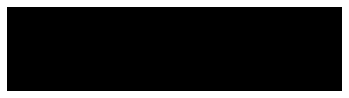

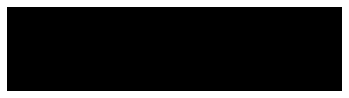

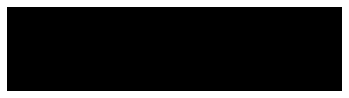

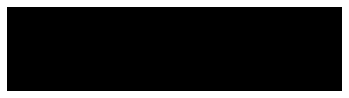

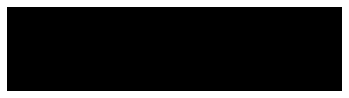

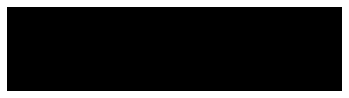

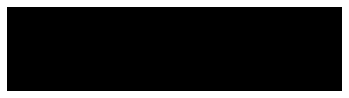

KeyboardInterrupt: 

In [46]:
from matplotlib import pyplot as plt
%matplotlib inline

env.configure({"manual_control": True, "real_time_rendering": True })
env.reset()
for _ in range(30):
    action = env.action_type.actions_indexes["IDLE"]
    obs, reward, done, info = env.step(action)
    plt.axis('off')
    plt.imshow(env.render(mode='rgb_array') )
    plt.show()

plt.imshow(env.render(mode="rgb_array"))
plt.show()

In [54]:
import gym
import highway_env

env = gym.make("highway-v0")
env.reset()
done = False
while not done:
    action = env.action_type.actions_indexes["IDLE"]
    obs, reward, done, info = env.step(action)
    env.render()

In [28]:
env.configure({"manual_control": True})
env.reset()
done = False
while not done:
    env.step(env.action_space.sample())

KeyboardInterrupt: 

In [61]:
import os 
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

def show_environment(env, steps=100):
    plt.axis('off')
    observation = env.reset()
    done = False
    for _ in range(steps): 
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done: 
            observation = env.reset()
        clear_output(wait=True)
        plt.axis('off')
        plt.imshow(env.render(mode='rgb_array') )
        plt.show()   
    return

pippo


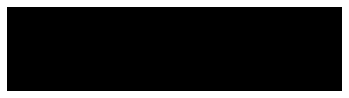

KeyboardInterrupt: 

In [62]:
show_environment(env, steps=100)

## Setup the agent

From the way we've set up our environment, a state is a list of 4 contiguous 84×84 pixel frames, and we have 5 possible actions. If we were to make a Q-table for this environment, the table would have $5×256^{84×84×4}$ values, since there are 5 possible actions for each state, each pixel has intensities between 0 and 255, and there are 84×84×4 pixels in a state. Clearly, storing a Q-table that large is impossible, so we have to resort to function approximation in which we use a neural network to approximate the Q-table.

### Function approximator

We use a convolutional neural net (which is ideal for image-based regression) with three convolutional layers and two linear layers. It takes two arguments: input_shape and output_dim. Of course, the input shape we will provide is 4×84×84, and there are 5 actions. 

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    
    def __init__(self, input_shape, n_actions):
        super(FCQ, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
                                  nn.ReLU(),
                                  nn.Conv2d(32, 64, kernel_size=4, stride=2),
                                  nn.ReLU(), 
                                  nn.Conv2d(64, 64, kernel_size=3, stride=1),
                                  nn.ReLU())

        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(nn.Linear(conv_out_size, 512), 
                                nn.ReLU(), 
                                nn.Linear(512, n_actions))
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device='cpu', dtype=torch.float32)
            x = x.unsqueeze(0)
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

### Replay Memory

In typical supervised learning, the neural network uses batches of data to update its weights. In deep Q-learning the idea is the same, except these batches of data are called batches of experiences, where an experience is a (state, action, reward, next_state, terminal) tuple. Instead of throwing away experiences, we can store them in a buffer to use later: the agent just has to sample a batch of experiences and use the double Q-update equation to update the network weights.

In [44]:
import numpy as np

class ReplayMemory():
    def __init__(self, state_space, max_size=10000, batch_size=64): 
        self.state_space = state_space
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
        
        self.states = torch.zeros(max_size, *self.state_space)
        self.actions = torch.zeros(max_size, 1)
        self.rewards = torch.zeros(max_size, 1)
        self.next_states = torch.zeros(max_size, *self.state_space)
        self.dones = torch.zeros(max_size, 1)

    def remember(self, state, action, reward, next_state, done):
        self.states[self.idx] = torch.Tensor(np.array([state])).float()
        self.actions[self.idx] = torch.tensor(np.array([action])).unsqueeze(0).float()
        self.rewards[self.idx] = torch.tensor(np.array([reward])).unsqueeze(0).float()
        self.next_states[self.idx] = torch.Tensor(np.array([next_state])).float()
        self.dones[self.idx] = torch.tensor(np.array([int(done)])).unsqueeze(0).float()
        self.idx += 1
        self.idx = self.idx % self.max_size
        self.size += 1
        self.size = min(self.size, self.max_size)

    def recall(self):
        idxs = np.random.choice(self.size, self.batch_size, replace=False)
        states = self.states[idxs]
        actions = self.actions[idxs]
        rewards = self.rewards[idxs]
        next_states = self.next_states[idxs]
        dones = self.dones[idxs]
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return self.size

### Exploration and evaluation strategies

We need to decide how to balance the exploration-exploitation trade-off, almost any technique would work fine. To keep things simple, we’re going to use an exponentially decaying epsilon-greedy exploration strategy. However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function.

In [45]:
class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action


In [46]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

### DDQN

As Rl algorithm we apply the Double Deep Q-Network, that utilises Double Q-learning to reduce overestimation of DQN by decomposing the max operation in the target into action selection and action evaluation. We evaluate the greedy policy according to the online network, but we use the target network to estimate its value.

In [47]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim
from tqdm import tqdm

class DDQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 seed, gamma, n_warmup_batches, target_update_steps):
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        self.env = env
        self.gamma = gamma
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

    def interaction_step(self, state):
        action = self.train_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = self.env.step(action)
        self.replay_memory.remember(state, action, reward, new_state, is_terminal)
        self.episode_rewards[-1] += reward
        return new_state, is_terminal
    
    def optimize_model(self):
        if len(self.replay_memory) < self.replay_memory.batch_size * self.n_warmup_batches:
            return
        states, actions, rewards, next_states, is_terminals = self.replay_memory.recall()
        max_a_q = self.target_model(next_states).max(1).values.unsqueeze(1)
        target = rewards + torch.mul(self.gamma * max_a_q, (1 - is_terminals))
        current = self.online_model(states).gather(1, actions.long())
        td_error = current - target
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()
    
    def update_network(self):
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, max_episodes):
        self.episode_rewards = []      
        results = np.empty(max_episodes)
        self.update_network()
        for episode in tqdm(range(1, max_episodes + 1), leave=True):                 
            episode_steps = 0;
            self.episode_rewards.append(0.0)
            state = self.env.reset()
            is_terminal = False
            for step in count():
                state, is_terminal = self.interaction_step(state)
                self.optimize_model()
                if episode_steps % self.target_update_steps == 0:
                    self.update_network()
                episode_steps += 1
                if is_terminal: break
            mean_reward = np.mean(self.episode_rewards[-10:])
            std_reward = np.std(self.episode_rewards[-10:])
            results[episode-1] = mean_reward
            debug_message = 'episode {:04}, score {:05.1f} ({:05.1f})'
            debug_message = debug_message.format(episode-1, mean_reward, std_reward)
            print(debug_message, end='\r', flush=True)
            training_is_over = episode >= max_episodes
            if training_is_over:
                break
        return results
    
    def evaluate(self, n_episodes=10):
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for step in count():
                a = self.eval_strategy.select_action(online_model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    

## Training the agent

In [ ]:
gamma = 0.90
learning_rate = 0.00035
max_episodes = 100

memory_size = 1000
batch_size = 54
n_warmup_batches = 3

target_update_steps = 100
seed = 42

space, actions = env.observation_space.shape, env.action_space.n
    
print('Training started...')
    
online_model = FCQ(space, actions)
target_model = FCQ(space, actions)
optimizer = optim.RMSprop(online_model.parameters(), lr=learning_rate)
replay_memory = ReplayMemory(state_space=space, max_size=memory_size, batch_size=batch_size)  
train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.4, decay_steps=2000000)
eval_strategy = GreedyStrategy()
        
agent = DDQN(env, online_model, target_model, optimizer, 
             train_strategy, eval_strategy, replay_memory, seed,
             gamma, n_warmup_batches, target_update_steps)

results = agent.train(max_episodes)

print('...training complete')   

Training started...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

  1%|▍                                          | 1/100 [00:01<01:49,  1.11s/it]

  2%|▊                                          | 2/100 [00:01<01:07,  1.45it/s]

  3%|█▎                                         | 3/100 [00:03<02:11,  1.35s/it]

  4%|█▋                                         | 4/100 [00:43<26:30, 16.57s/it]

  5%|██▏                                        | 5/100 [00:57<24:29, 15.47s/it]

  6%|██▌                                        | 6/100 [02:07<53:35, 34.21s/it]

  7%|███                                        | 7/100 [02:11<37:50, 24.41s/it]

  8%|███▍                                       | 8/100 [02:17<28:07, 18.34s/it]

  9%|███▊                                       | 9/100 [02:31<25:48, 17.02s/it]

 10%|████▏                                     | 10/100 [03:52<55:07, 36.75s/it]

 11%|████▍                                   | 11/100 [06:27<1:48:27, 73.12s/it]

 12%|████▊                                   | 12/100 [08:15<2:02:44, 83.69s/it]

 13%|█████▏                                  | 13/100 [08:27<1:29:50, 61.96s/it]

 14%|█████▌                                  | 14/100 [08:33<1:04:26, 44.95s/it]

 15%|██████                                  | 15/100 [10:38<1:38:00, 69.19s/it]

 16%|██████▍                                 | 16/100 [10:52<1:13:22, 52.41s/it]

 17%|███████▏                                  | 17/100 [11:06<56:48, 41.06s/it]

 18%|███████▏                                | 18/100 [13:15<1:32:07, 67.40s/it]

 19%|███████▌                                | 19/100 [13:29<1:09:25, 51.43s/it]

 20%|████████▍                                 | 20/100 [13:35<50:18, 37.73s/it]

 21%|████████▍                               | 21/100 [16:21<1:40:32, 76.36s/it]

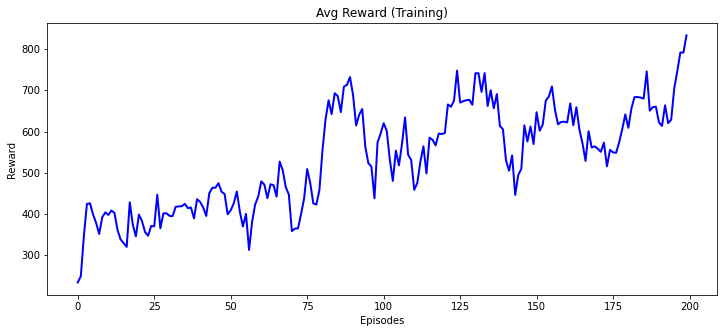

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(results, 'b', linewidth=2)
plt.title('Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

In [28]:
score, std = agent.evaluate(n_episodes=5)
print("score: ", score, " (", std , ")")

score:  -21.0  ( 0.0 )


## Exploit the policy

In [29]:
def show_policy(agent, env, steps=100):
    observation = env.reset()
    done = False
    for step in range(steps): 
        action = agent.eval_strategy.select_action(agent.target_model, observation)
        observation, reward, done, info = env.step(action)
        if done: 
            observation = env.reset()
        clear_output(wait=True)
        plt.axis('off')
        plt.imshow(env.render(mode='rgb_array') )
        plt.show()   
    return

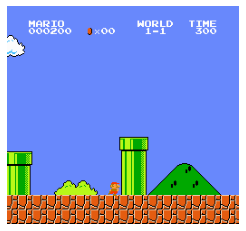

In [31]:
show_policy(agent, env, steps=500)